# 0. Введение.

Привет! Эта лабораторная работа про то, какие есть способы сбора данных с сайтов. Давай начнём с небольшого введения про то, как её выполнять.

В коде и тексте этой лабораторной работы встречаются блоки двух видов. Первый из них будет в ячейках с кодом и выглядит он так:


```
# TODO
```

Это означает, что тут надо написать одну или несколько строчек кода.

Второй тип блоков выглядит так - <font color='violet'> \# TODO </font>. Он означает, что тут надо написать какие-то свои мысли и выводы. Когда будешь писать, пожалуйста, не меняй цвет текста твоего ответа - это упростит проверку.

В тексте внизу собраны все нужные библиотечки - запускаем её и начинаем выполнение лабораторной работы! :)

In [ ]:
from urllib.request import urlopen
from urllib.parse import urlparse, urldefrag, urljoin
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import json

# Часть 1. Работа со статическими страницами при помощи bs4. 3 балла.



В этой части вам не нужно работать с маркетплейсами или сложными крупными онлайн-магазинами, достаточно поиграться с **небольшим нишевым магазинчиком**.

Пример сайта, подходящего под задание:
- Семена овощей - Аэлита https://ailita-shop.ru/


Вам нужно найти ПОХОЖИЙ сайт без динамической подгрузки контента (таких в интернете очень много)

Для формирования представления о магазине достаточно посмотреть на товары одной выбранной категории.

На странице товара **должна содержалась следующая информация, которую вам надо будет получить в рамках задания**:

- Название
- Картинка
- Характеристики (минимум 1)
- Описание

Описание должно быть достаточно большим (больше одного предложения) и содержать информацию о характеристиках товара. Например, как это бывает на алиэкспрессе

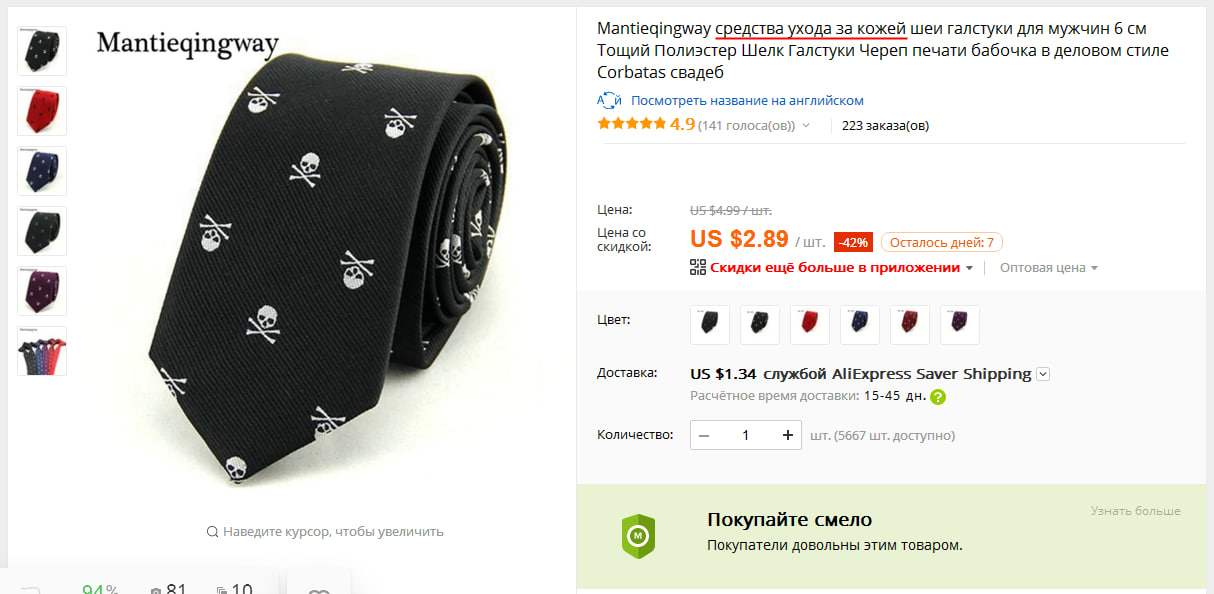

## Исследование

Выберите магазин, который удовлетворяет описанию магазина-конкурента:

<font color='violet'> \# https://antplanet.ru </font>

Выберите категорию товаров и посмотрите на предлагаемые карточки товаров. **Категория должна содержать 20+ карточек, чтобы можно было составить более полное мнение о товарах в магазине.**

In [ ]:
url = 'https://antplanet.ru/?utm_source=yandex&utm_medium=cpc&utm_campaign=AvtoRK-konversii2&type=search&source=none&block=premium&position=2&utm_term=%D0%BA%D1%83%D0%BF%D0%B8%D1%82%D1%8C%20%D0%BC%D1%83%D1%80%D0%B0%D0%B2%D1%8C%D0%B5%D0%B2&yclid=10737760511752929279'

Откройте ссылку с помощью библиотеки `urllib` и загрузите данные в переменную `html`. Не забудь про кодировку!

In [ ]:
import chardet
response = urlopen(url)
raw_data = response.read()

result = chardet.detect(raw_data)
encoding = result['encoding']

html = raw_data.decode(encoding)

Распарсьте текстовую информация на странице, используя библиотеку `bs4`



In [ ]:
soup = BeautifulSoup(html, 'html.parser')

Найдите все узлы href на странице

In [ ]:
hrefs = [a['href'] for a in soup.find_all('a', href=True)]

Сохраните полные адреса сслыкок в список


Подсказка: используйте `urljoin`

In [ ]:
links = [urljoin(url, href) for href in hrefs]

Какие ссылки соответствуют карточкам товаров? Выберите все такие ссылки. Для этого напишем функцию фильтрации, которая будет определять, является ли ссылка корректной

In [ ]:
def filter(links):
    pattern = re.compile(r'https://antplanet.ru/catalog/view/')
    filtered = set()

    for link in links:
        if pattern.match(link):
            filtered.add(link)

    return list(filtered)

In [ ]:
filtered_links = filter(links)

 На странице могло быть несколько ссылок, ведущих на одну и ту же карточку товара. Избавьтесь от дубликатов в списке ссылок

In [ ]:
filtered_links = filter(links)

Сколько получилось ссылок?

In [ ]:
print(filtered_links, len(filtered_links))

['https://antplanet.ru/catalog/view/724', 'https://antplanet.ru/catalog/view/744', 'https://antplanet.ru/catalog/view/753', 'https://antplanet.ru/catalog/view/623', 'https://antplanet.ru/catalog/view/239', 'https://antplanet.ru/catalog/view/192', 'https://antplanet.ru/catalog/view/240', 'https://antplanet.ru/catalog/view/750', 'https://antplanet.ru/catalog/view/736', 'https://antplanet.ru/catalog/view/637', 'https://antplanet.ru/catalog/view/638', 'https://antplanet.ru/catalog/view/738', 'https://antplanet.ru/catalog/view/639', 'https://antplanet.ru/catalog/view/635', 'https://antplanet.ru/catalog/view/741', 'https://antplanet.ru/catalog/view/740', 'https://antplanet.ru/catalog/view/193', 'https://antplanet.ru/catalog/view/190', 'https://antplanet.ru/catalog/view/735', 'https://antplanet.ru/catalog/view/238', 'https://antplanet.ru/catalog/view/754', 'https://antplanet.ru/catalog/view/752'] 22


Теперь, когда у нас есть ссылки на товары, давайте проанализируем, что этот магазин продает. Откройте страницу товара и посмотрите, какая информация там представлена и какую информацию вы хотите сохранить. **Обязательные** колонки:

- Название
- Картинка
- Характеристики (минимум 1) - для одежды это может быть ткань, из которой  она сшита, для семян овощей - срок созревания и.т.д.
- Описание

Можно **(и даже стоит)** добавить больше колонок, если получается выгрузить такую информацию.

In [ ]:
def extract_product_info(url):
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Ошибка при загрузке страницы: {response.status_code}")
        return None

    html = response.content.decode(response.encoding)
    soup = BeautifulSoup(html, 'html.parser')
    product_info = {}

    title = soup.find('h1', {'itemprop': 'name'})
    product_info['Название'] = title.get_text(strip=True) if title else 'Не найдено'

    image = soup.find('a', {'rel': 'image'})
    product_info['Картинка'] = image['href'] if image else 'Не найдено'

    characteristics = soup.find('span', {'itemprop': "price"})
    product_info['Характеристики'] = characteristics.get_text(strip=True) if characteristics else 'Не найдено'

    description = soup.find('div', {'class': 'single-product-description'})
    product_info['Описание'] = description.get_text(strip=True) if description else 'Не найдено'

    return product_info

print(extract_product_info('https://antplanet.ru/catalog/view/637'))

{'Название': 'Комплект с фермой СТАНДАРТ Sand PRO "Горный мох"', 'Картинка': 'https://antplanet.ru/img/goods/637.ceafd20deaf3908943ab1eb37da09809.jpg', 'Характеристики': '4900руб.', 'Описание': 'ПРЕИМУЩЕСТВА- Вместимость фермы до 2х тысяч муравьев!такой численности колония сможет достичь через 3-4 года!А когда муравьям станет тесно, вы можете подключить дополнительные ходы!- Встроенное автоувлажнение! Новая технология!Больше не нужны вертикально торчащие пробирки!Держит влагу до 2х недель!Не имеет аналогов!-\xa0Природный рельеф вместо плоского акрила.Рельефный дизайн ходов с углублениями, тоннелями и возвышенностями.-Долговечность.В фармике съемные гипсовые вставки.Муравьиная ферма полностью разборна.КОМПЛЕКТАЦИЯМуравьиная ферма Стандарт Sand PROДекоративная накладка "Горный мох"Муравьи жнецы (королева с рабочими)Запас корма на годПинцет для кормления и чистки фермыАнтипобегИнструкция по уходу за муравьями с полезными шпаргалкамиИнформационный буклет к муравьиной фермеВся необходимая ф

Напишите функцию, которая принимает ссылку на страницу и возвращает все необходимые признаки. Для этого давайте поймем, как работать сначала с одной ссылкой

Выберите первую ссылку из списка

In [ ]:
url = 'https://antplanet.ru/catalog/view/637'

Распечатайте ее

In [ ]:
print(url)

https://antplanet.ru/catalog/view/637


Используя библиотеку `requests` загрузите данные по сслыке и распартье их, как вы это делали ранее

In [ ]:
response = requests.get(url)
html = response.content.decode(response.encoding)
soup = BeautifulSoup(html, 'html.parser')

Посмотрите на полученные данные. В каком узле находится название товара? Сохраните этот узел и достаньте название товара

In [ ]:
print(soup)


<!DOCTYPE html>

<html>
<head>
<link href="/favicon.ico" rel="shortcut icon"/>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="1fd68953ee24bd3d" name="yandex-verification"/>
<meta content="3ec0b427b5b25f65f366e14442ba182c" name="cmsmagazine"/>
<meta content="telephone=no" name="format-detection"/>
<meta content="initial-scale=1.0, width=device-width" name="viewport"/>
<title>Купить комплект для формикария СТАНДАРТ "Горный мох" 15 мм, цены на AntPlanet. </title>
<meta content='Набор для содержания муравьев в домашних условиях "Горный мох". Есть все необходимое для этого. Звоните ☎  8 (800)350-38-48' name="description"> <meta content="Муравьиная ферма, Купить муравьев, Формикарий, Муравьи, Муравьиная ферма с муравьями, Купить муравьиную ферму в Москве, AntPlanet, Мини+, ферма муравьев, формикарий купить, купить муравьиную ферму с муравьями, муравьиная ферма москва, ферма AntPlanet" name="keywords"/>
<!--[if lt IE 9]><script type="text/javascript" src=

Проделайте аналогичные шаги, чтобы получить информацию для оставшихся колонок

In [ ]:
information = extract_product_info('https://antplanet.ru/catalog/view/637')

Достаньте описание товара

In [ ]:
description = information['Описание']

In [ ]:
print(description)

ПРЕИМУЩЕСТВА- Вместимость фермы до 2х тысяч муравьев!такой численности колония сможет достичь через 3-4 года!А когда муравьям станет тесно, вы можете подключить дополнительные ходы!- Встроенное автоувлажнение! Новая технология!Больше не нужны вертикально торчащие пробирки!Держит влагу до 2х недель!Не имеет аналогов!- Природный рельеф вместо плоского акрила.Рельефный дизайн ходов с углублениями, тоннелями и возвышенностями.-Долговечность.В фармике съемные гипсовые вставки.Муравьиная ферма полностью разборна.КОМПЛЕКТАЦИЯМуравьиная ферма Стандарт Sand PROДекоративная накладка "Горный мох"Муравьи жнецы (королева с рабочими)Запас корма на годПинцет для кормления и чистки фермыАнтипобегИнструкция по уходу за муравьями с полезными шпаргалкамиИнформационный буклет к муравьиной фермеВся необходимая фурнитура (пипетка, заглушки и т.д.)Красивая дизайнерская упаковкаПРИЯТНЫЕ БОНУСЫСувенир в подарок: фирменная ручка.Уникальная кормовая добавка БыстроРостЛЕГКО И ИНТЕРЕСНОКомплект подойдет "для нович

Если сайт соответсвует требованиям, то тут должно содержаться много полезной информации, которая не попала в карточку товара, но может быть интересна при исследовании. Выберите какую-нибудь часто встречающуюся в описаниях товаров характеристику и попробуйте вытащить информацию о ней с помощью регулярного выржения. Например, для плодовых культур такой харатеристикой может быть срок созревания первых плодов

Характеристика: <font color='violet'> \#Буду смотреть на характеристику сколько муравьёв помещается в ферме </font>

Используйте библиотеку `re` и напишите регулярное выражение для выделения данной харатеристики. Опишите, почему выбрано именно такое регулярное выражение и в чем его смысл:

In [ ]:
import re
pattern = r'вместимость фермы до (.+?) муравьев'

<font color='violet'> \#
Ищем в ранее полученно description вместимость фермы я посмотрел на странницах и она описыватеся так: вместимость фермы до (число оно бывает странно записано 2x тысячи поэтому (.+?)) в конце муравьев </font>

In [ ]:
match = re.search(pattern, description, re.IGNORECASE)
if match:
    print(match.group(1))
else:
    print("Совпадений не найдено.")

2х тысяч


Оформите полученные данные в датафрейм при помощи `Pandas`. Выведите записи.

In [ ]:
matches = []
print(filtered_links)
for link in filtered_links:
  print(extract_product_info(link))
  matches.append(extract_product_info(link))

df = pd.DataFrame(matches, columns=['Название', 'Картинка', 'Характеристики', 'Описание'])

print(df.to_string())

['https://antplanet.ru/catalog/view/724', 'https://antplanet.ru/catalog/view/744', 'https://antplanet.ru/catalog/view/753', 'https://antplanet.ru/catalog/view/623', 'https://antplanet.ru/catalog/view/239', 'https://antplanet.ru/catalog/view/192', 'https://antplanet.ru/catalog/view/240', 'https://antplanet.ru/catalog/view/750', 'https://antplanet.ru/catalog/view/736', 'https://antplanet.ru/catalog/view/637', 'https://antplanet.ru/catalog/view/638', 'https://antplanet.ru/catalog/view/738', 'https://antplanet.ru/catalog/view/639', 'https://antplanet.ru/catalog/view/635', 'https://antplanet.ru/catalog/view/741', 'https://antplanet.ru/catalog/view/740', 'https://antplanet.ru/catalog/view/193', 'https://antplanet.ru/catalog/view/190', 'https://antplanet.ru/catalog/view/735', 'https://antplanet.ru/catalog/view/238', 'https://antplanet.ru/catalog/view/754', 'https://antplanet.ru/catalog/view/752']
{'Название': 'Комплект Фармиков "Стартовый" Горный Мох', 'Картинка': 'https://antplanet.ru/img/go

Посмотрите на колонку, которая получилась после парсинга описания с помощью регулярных выражений и **ответьте на вопросы**:
1. Сколько получилось заполненных ячеек? Сколько это составляет процентов от общего количества?
2. Во всех ли ячейках адекватная информация?
3. Если что-то некорректно заполнилось, то почему такое произошло?

<font color='violet'> \# 1) незаполнеными остались всего 6 ячеек (6/22*4) = 6.8%
2)во всех (даже в 6 пустых просто описание товаров отсутствует) 3) 2 ссылка напримр в ней некореектно заполнено описание, на сайте его просто нет, от того там ничего и нет
 </font>

# Часть 2. Изучение ограничений парсинга. 1 балл.

В рамках изучения конкурентов мы также узнали, что у них есть магазины **на Ozon**. Преисполнившись уверенностью после легкого парсинга сайта-магазина конкурентов, мы решили, что теперь мы готовы парсить большие маркетплейсы. В следующих ячейках попробуй проделать те же шаги, которые делались в части 1 этой лабораторной работы.

Запишем ссылку на товар компании-конкурента. Попробуем обратиться к ней через response; после этого посмотрим на ответ. Если в ответе есть русские символы, то проверим кодировку - чтобы они корректно отображались, строка должна быть в utf-8. Для этого могут помочь методы `encode` и `decode`.

Примеры подходящих ссылок согласно примерам из части 1 этой лабораторной:

- Семена кабачков 'https://www.ozon.ru/product/semena-kabachok-babe-schaste-2-gr-semena-altaya-864807018/'

In [ ]:
import requests

url_ozon = 'https://www.ozon.ru/product/kombo-nabor-pahlavy-400-200-g-1424363321/?advert=AP0AoLSom3qNPIcaNav6Ggj_oyyrH4_d21DYV7ATyGOXrDkU4GyJbWzUNNAkinCXI5fhW2ehps_xeWuVHy8M_q4GhRi91qEgOwzGvMOu1L2i51_iNNbbs1sN1LRjNIEDDrzyk_ZiUGW6d77ZNiYYgeU04zfPrwbJK5EUlVEHGDbNThDvxBfVgsLQks_IuQ7LT5nxlFNLpm7R_Lxh98DO0XbcnFNEu5TxgIMt_3N73pyPASnbLEvOSBIn1SbF&from_sku=1378492777&oos_search=false'
response = requests.get(url_ozon)

if response.encoding != 'utf-8':
    response.encoding = 'utf-8'

content = response.text

Выведи текст ответа

In [ ]:
print(content)



    <!DOCTYPE html><html lang="ru"><head><meta content="text/html; charset=utf-8" http-equiv="Content-Type"><meta name="viewport" content="width=device-width,initial-scale=1,minimum-scale=1"><meta name="robots" content="noindex, nofollow"><link rel="stylesheet" href="https://cdn1.ozone.ru/s3/abt-complaints/static/v1/common.css"><style>.con {overflow: auto;margin: auto;}  .mc {max-width: 420px;padding: 0 16px;overflow: auto}  .bc {padding-top: 32px}  h1 {margin: 24px 0 8px 0}  .tc {padding: 8px 0}  ul {margin: 8px 0 8px 0;padding-left: 24px}  .h {font-size: 12px;line-height: 16px;color: rgba(0, 26, 52, .6)}  .rb {margin-bottom: 16px}  .sb {background-color: transparent;color: var(--ctrlPrimary);padding: 6px}  .sb:hover {color: var(--hoverPrimary)}  .im {margin-left: -16px;width: 144px}  @media (max-width: 375px) {  .im {width: 104px}  h1 {margin-top: 20px;font-size: 20px;line-height: 24px}  .bc {padding-bottom: 50px}  .tc {color: rgba(0, 26, 52, .6)}  }</style><title>Доступ ограничен<

Какую страницу вывело? Та ли эта страница, которая доступна по ссылке в браузере?

Изучи в интернете, что привело к такому результату и какие есть способы обхода этой ошибки. **Результаты опиши в выводе к этой части.**

Выводы: <font color='violet'> \# Никакую страницу не вывело. Защита от ботов: Многие сайты, включая Ozon, используют системы защиты от автоматизированного доступа (ботов). Если ваш запрос выглядит как запрос от бота (например, слишком много запросов за короткий период времени или отсутствие необходимых заголовков), сервер может временно заблокировать ваш IP-адрес или ограничить доступ. Ещё пишут что многут быть проблемы с vpn и.т.д. Исправить проблему может помочь Использование заголовков (Headers) Использование сессий Аутентификация  </font>

# Часть 3. Парсинг динамического контента при помощи регулярных выражений. 1 балла.

Теперь, когда мы поняли, что ребята продают, важно понять как они это продают. У веб-магазинов часто есть странички в соцсетях для продвижения бренда. **Главная задача в этой части работы - проанализировать контент.** Для этого будем использовать ютуб :)

Найдите ютуб-канал вашего интернет-магазина. Если такого нет, то подойдет любой канал со схожей тематикой

Название канала: <font color='violet'> \# @AntPlanet </font>

Сохраните ссылку на страничку с роликами на этом канале

In [ ]:
url = 'https://www.youtube.com/@AntPlanet/videos'

Распарсьте страничку с помощью `bs4` и выведите список видео этого канала


In [ ]:
response = urlopen(url)
raw_data = response.read()

result = chardet.detect(raw_data)
encoding = result['encoding']

html = raw_data.decode(encoding)

soup = BeautifulSoup(html, 'html.parser')
print(html)

Для парсинга можно использовать различные подходы

Используя знания о том, что `html` документ - это дерево, попробуйте достать названия видео, как вы извлекали характеристики товаров в предыдущей части. Здесь постарайтесь не использовать регулярные выражения или поясните, почему не получается извлечь информацию без них

In [ ]:
#TODO

<script nonce="jUh0eRn8Fvch5GAwVTqLCQ">var ytInitialData = {"responseContext":{"serviceTrackingParams":[{"service":"GFEEDBACK","params":[{"key":"route","value":"channel.videos"},{"key":"is_casual","value":"false"},{"key":"is_owner","value":"false"},{"key":"is_alc_surface","value":"false"},{"key":"browse_id","value":"UCwmXF9H4u7KmJwqUwHcCQow"},{"key":"browse_id_prefix","value":""},{"key":"logged_in","value":"0"},{"key":"e","value":"9407157,23804281,23946420,23966208,23998056,24004644,24007613,24077241,24166867,24173288,24181174,24241378,24290971,24439361,24453989,24456089,24459436,24466624,24468724,24542367,24548627,24548629,24550458,24566687,24699899,39325347,39325801,39325818,39325854,39326323,39326376,39326395,39326418,39326462,39326498,39326516,39326587,39326596,39326610,39326620,39326642,39326681,39326794,39326848,39326860,51009781,51010235,51016856,51017346,51020570,51025415,51030101,51033765,51037346,51037353,51041512,51050361,51053689,51057846,51057851,51060353,51063643,51064835

Используя регулярные вырежения извлеките названия видео из целого `html` документа

In [ ]:
#TODO

['КАК ДЕШЕВО ВЫЛЕЧИТЬ ЛЮБЫЕ БОЛЕЗНИ РАСТЕНИЙ?', 'ТОП-10 ПОЛЕЗНЫХ СОВЕТОВ для ОГОРОДА в ИЮЛЕ', 'В ЭТО СТОИТ ВЛОЖИТЬСЯ! Капельный полив', 'ЧТО ПОСЕЯТЬ в ИЮЛЕ и СОБРАТЬ УРОЖАЙ в 2024?', 'МУЧНИСТАЯ РОСА на ОГУРЦАХ, СМОРОДИНЕ, РОЗАХ, КРЫЖОВНИКЕ... ЧЕМ ЛЕЧИТЬ?', 'КАК ИЗБАВИТЬСЯ ОТ МУРАВЬЕВ НАВСЕГДА? Спойлер: никак', 'ПОСЛЕ ЭТОГО ТОМАТЫ НЕ ЗАБОЛЕЮТ! Профилактика болезней томатов', 'КАК ЛЕЧИТЬ СКРУЧЕННЫЕ ЛИСТЬЯ НА ТОМАТАХ?', 'ФОРМИРОВКА ТОМАТОВ  1, 2, 3, 4 СТЕБЛЯ!', 'НЕ ПРИМЕНЯЙТЕ ФИТОВЕРМ ПОКА НЕ ПОСМОТРИТЕ ВИДЕО!', 'УДОБРЕНИЯ НА ЛЕТО! Что нужно иметь в запасе?', 'ЧТО СЕЯТЬ В ИЮНЕ?!', 'У ВАС ТОЧНО ВЫРАСТЕТ АРБУЗ! Все о выращивании арбузов', 'ПРАВИЛА ПОСАДКИ КЛУБНИКИ ВЕСНОЙ!', 'ВАЖНО ЗНАТЬ ПРИ ВЫСАДКЕ ЦВЕТОВ!', 'ВЗОЙДЕТ ЛЮБАЯ МОРКОВЬ! Посев на богатый урожай', 'ПРОСТЫЕ ПРАВИЛА ПОСАДКИ КАРТОФЕЛЯ!', 'КАК ВЫСАДИТЬ ТОМАТЫ, ЕСЛИ ВЫТЯНУЛИСЬ? Посадка лежа', 'СДЕЛАЙТЕ ЭТО ПЕРЕД ВЫСАДКОЙ РАССАДЫ!', 'УСПЕВАЙТЕ! Что посеять в мае?', 'УКРОП, ПЕТРУШКА, БАЗИЛИК ВЗОЙДУТ ДРУЖНО! Если знать...', 'ПРОВОЛОЧНИК У

Напишите выводы, отвечая на следующие вопросы

1. Какой из рассмотренных методов в данной ситуации подходит лучше и почему?
2. Получилось ли у вас загрузить все видео с канала за один запрос? Поясните полученные результаты
3. Когда стоит использовать регулярные выражения, а когда хождение по дереву с помощью `bs4`? Приведите примеры
4. С какими проблемами вы столкнулись во время работы и почему они возникли?

<font color='violet'> \# TODO </font>

# Часть 4. Парсинг динамическго контента при помощи selenium. 2 балла.

Немного магии из интеренета, чтобы другая магия заработала

In [ ]:
# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpad

In [ ]:
!pip install chromedriver-autoinstaller

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

'/usr/local/lib/python3.10/dist-packages/chromedriver_autoinstaller/131/chromedriver'

In [ ]:
# set up the webdriver
driver = webdriver.Chrome(options=chrome_options)

In [ ]:
driver.get('https://www.youtube.com/@AntPlanet/videos')

Используя библиотеку `BY` найдите названия видео

In [ ]:
video_titles = driver.find_elements(By.ID, "video-title")
for title in video_titles:
    print(title.text)
driver.quit()

AntPlanet живодёры! Зачем они это делают?!
Конденсат в муравьиной ферме / Откуда конденсат в формикарии и как от него избавиться
Какие муравьи живут в природе Кавказских гор / Как поймать матку муравьёв
Как выглядела первая муравьиная ферма / Производство муравьиных ферм / Фармик на магнитах
From chrysalis to ant. As close as possible! To end. AntPlanet.
Overview to the Ark farm. Vertical farm from AntPlanet.
POPULATED
Farmaci. Fire novelty. Unbelievable!
HALLOWEEN STORY. The most creepy farm! Watch until the end.
БРАК? А ВОТ ТАК! ВЗОРВАЛ ФЕРМУ. ШОК!
Antireality 1.17, 2.10, 3.6, 4.3-Global release!
That gift arrived! Unpacking, décor and check-in.
AntReality 3.5 - Где цветок?
AntReality 4.2 - Наведём-ка порядок!
Self-build farm AntPlanet "Standard"
Self-build farm AntPlanet "Mini"
Блиц-опрос от Ани!
AntReality 1.16 Жнецы готовятся к побегу! Эксперимент.
AntReality 4.1 - Camponotus xerxes.
Remove-decorate
Блиц-опрос для Максима
A fun quiz for Nastya
AntReality 1.15, 2.8, 3.4 - Сравнение

Получилось ли загрузить все видео? Почему?

<font color='violet'> \# Все загрузить не получилось, так как ютуб подгружает видео с прокруткой страницы вниз, а в коде это не было реализовано </font>

Используя методы `selenium` сделайте так, чтобы прогрузилась вся страничка с видео канала и соберите названия видео

In [ ]:
url = 'https://www.youtube.com/@AntPlanet/videos'
driver.get(url)

time.sleep(3)

pause_time = 2
height = driver.execute_script("return document.documentElement.scrollHeight")  #высота страницы
temp = 0
while temp < 5:
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
    time.sleep(pause_time)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    temp += 1
    if new_height == height:
        break
    height = new_height

titles = driver.find_elements(By.ID, "video-title")

for title in titles:
    print(title.text)



Какая еще информация может быть полезна при анализе конкурентов? Попробуйте достать эту информацию с канала с помощью библиотеки `selenium` и поясните, почему вам нужны именно эти данные:

<font color='violet'> \# Просмотры на видеороликах. Можно понять к примеру какая муравьиная ферма лучшая. </font>


 Прежде чем приступить к заданию предложите другие методы получения этих данных и подумайте, почему вам необходимо использовать именно `selenium`:


<font color='violet'> \# Я мог бы парсить страницу как и раньше, но это было бы сложнее из-за ограниченности запросов к ютубу (ютуб сложный сайт не то что сайт по муравьям), selenuim решает проблему </font>

Теперь, когда вы понимаете, что и зачем вы будете делать, можно приступать. Напишите необходимый код

In [ ]:
driver.quit()

<font color='red'> Не забудь закрыть сессию браузера selenium! Каждый день умирают 10 морских котиков из-за того, что беспечные программисты забывают закрывать сессии и чистить за собой данные. Если не закроешь - снимем много баллов! </font>

Сделайте выводы:

1. Какова тематика канала? Какой контент преобладает на канале?
2. Если бы вы создавали аналогичный магазин, с каким содержанием ролики вам стоило бы выпускать?
3. Какие выводы вы можете сделать из собранных вами данных? Оказались ли эти данные полезны или стоило потратить время на сбор другой информации?

<font color='violet'> \# 1) Муравьи, их содержание 2) Больше интресных "игр" с муравьями, скармливать им разные вещи, смотреть как они поведут себя встретив предмет и.т.д 3) Да данные довольно полезны  </font>

# Часть 5. Получение контента через API. 2 балла.

На семинарах изучались основы взаимодействия с API (если не уверены в своих силах, сейчас самое время погуглить про API самим в интернете). Изучите документацию `API YouTube`, чтобы получить комментарии под видео конкурента через API.

Теперь должно быть примерно понятно, как создать ключ для API. Аутентификация здесь не понадобится, нужен только ключ.

<font color='red'> Не забудь удалить API ключ доступа перед отправкой на проверку. Ежедневно 20 морских котиков умирают из-за того, что нерадивые программисты забывают удалить приватный API ключ доступа и заливают код в публичный репозиторий. После этого китайские хакеры получают все доступы после того, как воспользовавшись кодом из частей 3-4 этой лабораторной, скрапят эти ключи из публичных репозиториев. Если ты не удалишь ключ - мы снимем очень много баллов. </font>

In [ ]:
yt_api_key = '...'

Теперь выбери видео про товар конкурента, в котором **больше тысячи комментариев**. Давай попробуем получить их. Для начала достаточно получить лишь начальные комментарии каждого треда (посмотри в документации `YouTube API`, что такое `commentThreads`).

В следующей ячейке укажи ссылку на видео (скопируй из адресной строки браузера) и получи из неё ID видео.

In [ ]:
video_url = 'https://www.youtube.com/watch?v=rYgrdkrc5_A&t=201s'
video_id = video_id = video_url.split("v=")[-1]

Теперь надо на основе ID видео и ключа API легко получить запрос API, который нам вернёт инфрмацию в формате JSON. Сформируем ссылку, в которой будут находиться необходимые параметры и напишем запрос. Выведем, что вернул запрос

In [ ]:
url_method = (
    f"https://www.googleapis.com/youtube/v3/commentThreads?"
    f"part=snippet&videoId={video_id}&key={yt_api_key}&maxResults=20"
)

response = requests.get(url_method)

In [ ]:
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print(f"error: {response.status_code}, {response.text}")

Сколько комментариев получилось спарсить в рамках одного запроса? Это все комментарии, которые есть на страничке?

Какой есть ключ в ответе на запрос, чтобы получить больше комментариев?

<font color='violet'> \# На странице отображается не весь список комментариев, а только первые 20 из них. Однако можно увеличить это значение до 100. В ответе присутствует ключ nextPageToken, который используется для запроса следующей страницы комментариев. </font>

Дело осталось за малым. Укажем, какой максимум комментариев можно получить за один запрос; допишем код в цикле, чтобы получить все комментарии и положить их в список `comments_lst`.  

В цикле **обязательно** используй try и catch, чтобы ловить ошибки - глюки и ошибки случаются, будет неприятно, если это повлияет на код

In [ ]:
import requests

RESULTS_AM = 100
base_url = "https://www.googleapis.com/youtube/v3/commentThreads"

curr_results = RESULTS_AM
nextPageToken = ''
comments_lst = []

In [ ]:
while curr_results == RESULTS_AM:
    try:
        params = {
            "part": "snippet",
            "videoId": video_id,
            "key": yt_api_key,
            "maxResults": RESULTS_AM,
            "pageToken": nextPageToken
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            comments = [
                item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                for item in data["items"]
            ]
            comments_lst.extend(comments)
            nextPageToken = data.get("nextPageToken", "")
            curr_results = len(data["items"])

        else:
            print(f"Ошибка: {response.status_code}, {response.text}")
            break

    except Exception as e:
        print(f"Ошибка в обработке запроса: {e}")
        break

In [ ]:
print(f"Всего: {len(comments_lst)}")
for comment in comments_lst[:37]:
    print(comment)

Изучи полученный список комментариев `comments_lst`. Сделайте выводы:

1. Как люди реагируют на содержание ролика? Что они отмечают в комментариях чаще всего, что было бы важно для вас как человека, открывающего магазин в этой сфере?
2. Предложите метод(-ы) фильтрации неинформативных комментариев. Какая ожидается точность, много ли комментариев на самом деле нужных будет отсеяно? Какие есть ограничения у метода(-ов)?
3. Сравните применение API и скрапинга динамической страницы при помощи selenium (комментарии YouTube так же можно скрапить, как вы делали в части 4). Какие ограничения у способов, какой вам нравится больше?

<font color='violet'> \# 1) Положительно угорают и шутят 2) Можно как-то регулярками обрабатывать "крутое видео" "вы лучшее"... Ну в регулярках не всё можно записать 3) API обеспечивает структурированные данные, быстрее и надежнее, но может иметь ограничения по доступности. Скрапинг с Selenium позволяет извлекать динамический контент, включая комментарии YouTube, но медленнее и подвержен изменениям страниц. Я предпочитаю API за его простоту и стабильность, но скрапинг полезен при отсутствии API. </font>

# Выводы. 1 балл

В рамках выводов тебе нужно:
- Подытожить результаты экспериментов в частях 1 - 5 лабораторной работы
- Объяснить, как каждый из методов, перечисленных в данной лабораторной работе, используется на практике, какие у него ограничения. Приведи примеры.
- Поделиться впечатлениями от лабораторной работы - что тебе понравилось,  что узнал нового; а что далось тяжелее всего.

<font color='violet'> \# Практически все эксперименты прошли успешно, и результаты соответствуют ожиданиям. Используемые методы: парсинг HTML с помощью BeautifulSoup, который актуален, когда невозможно получить данные через API или требуется простая информация, например, ссылки. Ограничения: при работе с динамическими данными его эффективность снижается. Автоматизация браузера с использованием Selenium решает проблему, позволяя парсить динамические страницы, но имеет недостатки, такие как медленная скорость работы и необходимость наличия драйвера. API я уже применял в проекте для получения котировок, поэтому здесь все понятно. Минусами являются ограничения на количество запросов, но эту проблему можно решить при наличии достаточной стипендии. </font>

# Бонусное задание (2 балла)

В рамках части 2 этой лабораторной работы мы поняли, что не всегда сайты готовы легко делиться данными. Изучив варианты, мы узнали, что есть разные варианты, как обойти ограничение.

**Задача**: обойди это ограничение на OZON в рамках кода на питоне. Нужно спарсить удачно хотя бы одну страничку.

Как один из возможных вариантов - изучи библиотеку https://github.com/ultrafunkamsterdam/undetected-chromedriver

In [ ]:
# TODO